# Imitation Learning for Portfolio Management using CNN

**Steps to try:**
1. We first try to overfit a 3 stocks toy case using 3 years of training data.
2. Try to generalize to other years of the same stock.
3. Get some insigts on network topology and hyperparameter tuning.
4. Increase the number of stocks. (Increase action space to more than 10.)

**Possible improvement methods:**
1. Use correlated action noise
2. Use adaptive parameter noise

**Figures to show:**
1. Training: total rewards w.r.t episode
2. How the model performs on training data
3. How the model performs on testing data

## Setup

In [2]:
import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index
import matplotlib.pyplot as plt
# for compatible with python 3
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# force tensorflow to use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
%qtconsole

In [4]:
# read the data and choose the target stocks for training a toy example
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]
target_stocks = ['AAPL', 'CMCSA', 'REGN']
training_date_start = '2012-08-13'
training_date_end = '2015-08-13'  # three years training data
training_index_start = date_to_index(training_date_start)
training_index_end = date_to_index(training_date_end)
target_history = np.empty(shape=(len(target_stocks), training_index_end - training_index_start, history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), training_index_start:training_index_end, :]

In [5]:
# collect testing data
testing_date_start = '2015-08-13'
testing_date_end = '2017-08-12'
testing_index_start = date_to_index(testing_date_start)
testing_index_end = date_to_index(testing_date_end)
testing_history = np.empty(shape=(len(target_stocks), testing_index_end - testing_index_start, history.shape[2]))
for i, stock in enumerate(target_stocks):
    testing_history[i] = history[abbreviation.index(stock), testing_index_start:testing_index_end, :]
# normalize
for i in range(target_history.shape[0]):
    for j in range(target_history.shape[1]):
        target_history[i][j] = target_history[i][j]/np.linalg.norm(target_history[i][j])
for i in range(testing_history.shape[0]):
    for j in range(testing_history.shape[1]):
        testing_history[i][j] = testing_history[i][j]/np.linalg.norm(testing_history[i][j])

In [6]:
print(target_history.shape)
print(testing_history.shape)

(3, 1095, 4)
(3, 730, 4)


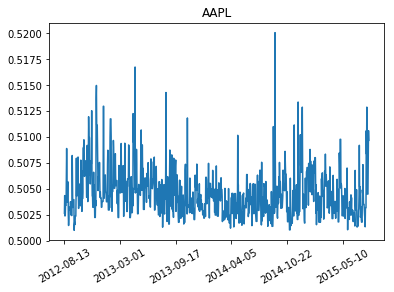

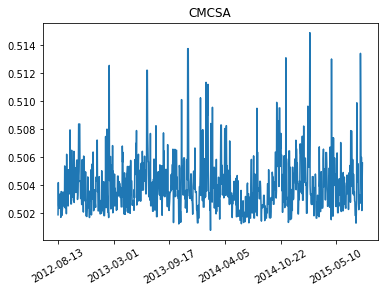

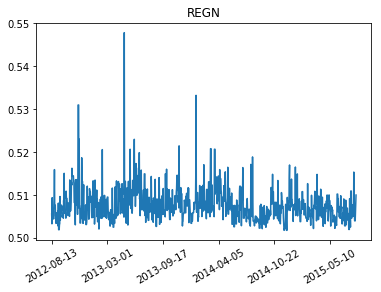

In [7]:
# visualize 3 stock open price
date_list = [index_to_date(i) for i in range(target_history.shape[1])]
x = range(target_history.shape[1])
for i in range(len(target_stocks)):
    plt.figure(i)
    plt.plot(x, target_history[i, :, 1])  # open, high, low, close = [0, 1, 2, 3]
    plt.xticks(x[::200], date_list[::200], rotation=30)
    plt.title(target_stocks[i])
    plt.show()

In [8]:
from environment.portfolio import PortfolioEnv
env = PortfolioEnv(target_history, target_stocks, window_length = 1)
print(env.window_length)
print(env.num_stocks)
print(env.sim.cost)

1
3
0.0025


In [9]:
# Reshape training and testing data
trainX = np.zeros(((target_history.shape[1]-env.window_length)*(env.num_stocks+1), 4, env.window_length+1, env.num_stocks))
testX = np.zeros(((testing_history.shape[1]-env.window_length)*(env.num_stocks+1), 4, env.window_length+1, env.num_stocks))
trainY = np.zeros(((target_history.shape[1]-env.window_length)*(env.num_stocks+1), env.num_stocks+1))
testY = np.zeros(((testing_history.shape[1]-env.window_length)*(env.num_stocks+1), env.num_stocks+1))
for i in range(target_history.shape[1]-env.window_length):
    for stockHeld in range(env.num_stocks + 1):
        for j in range(4):
            for windowIndex in range(env.window_length):
                for stock in range(env.num_stocks):
                    trainX[i*(env.num_stocks+1)+stockHeld][j][windowIndex][stock] = target_history[stock][i+env.window_length-windowIndex-1][j]
            if stockHeld > 0:
                trainX[i*(env.num_stocks+1)+stockHeld][j][env.window_length][stockHeld-1] = 1

for i in range(testing_history.shape[1]-env.window_length):
    for stockHeld in range(1, env.num_stocks + 1):
        for j in range(4):
            for windowIndex in range(env.window_length):
                for stock in range(env.num_stocks):
                    testX[i*(env.num_stocks+1)+stockHeld][j][windowIndex][stock] = testing_history[stock][i+env.window_length-windowIndex-1][j]
            if stockHeld > 0:
                testX[i*(env.num_stocks+1)+stockHeld][j][env.window_length][stockHeld-1] = 1
for i in range(target_history.shape[1]-env.window_length):
    for stockHeld in range(env.num_stocks+1):
        bestRate = 1.0
        bestStock = -1
        for stock in range(env.num_stocks):
            trading_cost = env.sim.cost
            if stockHeld-1 == stock:
                trading_cost = 0
            # print(trainX[i*(env.num_stocks+1) + stockHeld][3][0][stock], target_history[stock][i+env.window_length-1][3])
            rate = target_history[stock][i+env.window_length-1][3]/target_history[stock][i+env.window_length-1][0] - trading_cost
            if rate > bestRate:
                bestRate = rate
                bestStock = stock
        trainY[i*(env.num_stocks+1) + stockHeld][bestStock+1] = 1
for i in range(testing_history.shape[1]-env.window_length):
    for stockHeld in range(env.num_stocks+1):
        bestRate = 1.0
        bestStock = -1
        for stock in range(env.num_stocks):
            trading_cost = env.sim.cost
            if stockHeld-1 == stock:
                trading_cost = 0
            rate = testing_history[stock][i+env.window_length-1][3]/testing_history[stock][i+env.window_length-1][0] - trading_cost
            if rate > bestRate:
                bestRate = rate
                bestStock = stock
        testY[i*(env.num_stocks+1) + stockHeld][bestStock+1] = 1

        

In [10]:
from model.supervised.cnn import CNN
# instantiate CNN model
cnn_model = CNN(env=env)
cnn_model.build_model(load_weights=False)

Using TensorFlow backend.
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


Built model from scratch


In [11]:
# starts to train the model, hopefully it would work
cnn_model.train(trainX, trainY)

Epoch 1/10
4376/4376 [==============================] - 4s - loss: 5.8845 - acc: 0.2347     
Epoch 2/10
4376/4376 [==============================] - 4s - loss: 6.5143 - acc: 0.2514     
Epoch 3/10
4376/4376 [==============================] - 4s - loss: 5.4075 - acc: 0.2278     
Epoch 4/10
4376/4376 [==============================] - 4s - loss: 6.1577 - acc: 0.2356     - ETA: 
Epoch 5/10
4376/4376 [==============================] - 4s - loss: 5.3662 - acc: 0.2242     
Epoch 6/10
4376/4376 [==============================] - 4s - loss: 4.1719 - acc: 0.2246     
Epoch 7/10
4376/4376 [==============================] - 4s - loss: 3.9642 - acc: 0.2253     
Epoch 8/10
4376/4376 [==============================] - 4s - loss: 3.9535 - acc: 0.2233     
Epoch 9/10
4376/4376 [==============================] - 4s - loss: 4.0419 - acc: 0.2230     
Epoch 10/10
4376/4376 [==============================] - 4s - loss: 3.9527 - acc: 0.2228     
Finish.


In [85]:
# test model
predictions = cnn_model.predict(testX)
for i in range(len(predictions)):
    print(predictions[i], testY[i])
score = cnn_model.evaluate(testX, testY)
print(score)

Using Theano backend.


[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.

[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.

[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.

[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 

[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.

[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.

[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251

[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.

In [ ]:
ddpg_model_from_file = DDPG(env=env)
ddpg_model_from_file.build_model(load_weights=True)

In [ ]:
# evaluate the model with training data
env = PortfolioEnv(target_history, target_stocks)
observation, action = env.reset()
done = False
while not done:
    observation = observation[:, :, 3] / observation[:, :, 0]
#     print(observation)
    observation = np.expand_dims(observation, axis=-1)
    action = ddpg_model_from_file.predict(observation)
    action = np.squeeze(action, axis=0)
#     print(action)
#     input('Press any key to continue...')
    observation, _, done, _ = env.step(action)
env._render()

In [ ]:
# evaluate the model with unseen data from same stock
env = PortfolioEnv(testing_history, target_stocks, steps=650, start_idx=testing_index_start, 
                   sample_start_date='2015-10-02')
observation, action = env.reset()
done = False
for i in range(10):
    observation = observation[:, :, 3] / observation[:, :, 0] * 100
    observation = np.expand_dims(observation, axis=-1)
    action = ddpg_model_from_file.predict(observation)
    action = np.squeeze(action, axis=0)
#     print(action)
    observation, _, done, _ = env.step(action)
env._render()

In [ ]:
np.savez('temp/total_reward_state_1.npz', stat=ddpg_model.total_reward_stat)

In [ ]:
# plot episode reward and save it
total_reward_stat = np.load('temp/total_reward_state_1.npz')['stat']
x = range(len(total_reward_stat))[::20]
plt.plot(x, total_reward_stat[::20])
plt.xlabel('Episode')
plt.ylabel('Reward')

In [ ]:
# collect testing data of another 3 different companies
target_stocks = ['GOOGL', 'CSX', 'MAR']
testing_date_start = '2012-08-13'
testing_date_end = '2017-08-12'
testing_index_start = date_to_index(testing_date_start)
testing_index_end = date_to_index(testing_date_end)
testing_history = np.empty(shape=(len(target_stocks), testing_index_end - testing_index_start, history.shape[2]))
for i, stock in enumerate(target_stocks):
    testing_history[i] = history[abbreviation.index(stock), testing_index_start:testing_index_end, :]

In [ ]:
# evaluate the model with unseen data from different stocks
env = PortfolioEnv(testing_history, target_stocks, steps=1700, start_idx=testing_index_start)
observation, action = env.reset()
done = False
while not done:
    observation = observation[:, :, 3] / observation[:, :, 0]
    observation = np.expand_dims(observation, axis=-1)
    action = ddpg_model.predict(observation)
    action = np.squeeze(action, axis=0)
    observation, _, done, _ = env.step(action)
env._render()

In [ ]:
ddpg_model.actor.model.save_weights(ddpg_model.actor_path)
ddpg_model.critic.model.save_weights(ddpg_model.critic_path)
ddpg_model.actor.target_model.save_weights(ddpg_model.actor_target_path)
ddpg_model.critic.target_model.save_weights(ddpg_model.critic_target_path)

In [ ]:
layer_index = 1
# check model load
ddpg_model.actor.model.get_layer(index=layer_index).get_weights()

In [ ]:
ddpg_model_from_file.actor.model.get_layer(index=layer_index).get_weights()